In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

In [85]:
users = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1")

In [86]:
engage = pd.read_csv('takehome_user_engagement.csv', encoding = "ISO-8859-1")

In [87]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [88]:
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


# Identify "Adopted User"

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period.

In [89]:
engage['time_stamp'] = pd.to_datetime(engage['time_stamp']).dt.normalize()

In [90]:
engage.sort_values(by=['time_stamp'], ascending=True, inplace=True)

In [91]:
date = pd.DataFrame()
date['start'] = engage['time_stamp']
date['end'] = engage['time_stamp'] + timedelta(days=6)

In [92]:
date.drop_duplicates(inplace=True)

In [93]:
uid = []
for i in range(len(date)):
    mask = (engage['time_stamp'] >= date['start'].iloc[i]) & (engage['time_stamp'] <= date['end'].iloc[i])
    temp = engage.loc[mask]
    temp = temp.groupby(['user_id']).size().reset_index()
    uid.extend(list(temp['user_id'].loc[temp[0]>2]))

In [94]:
uid = list(set(uid))

In [95]:
print("Out of a total of", len(engage.user_id.unique()), 'users,',  "{:.0%}".format(len(uid) / len(engage.user_id.unique())), 
      "of them are adopted users.")

Out of a total of 8823 users, 18% of them are adopted users.


#### Create the response variable "adopted"

Now create a dummy variable 'adopted' in the users dataset indicating whether or not the user is an adopted user. This will be the response variable in our model.

In [96]:
users['adopted'] = users['object_id'].isin(uid)

# Feature Engineering

## Extract Email

In [97]:
users['email'] = users['email'].apply(lambda x: x.split("@",1)[1])

In [98]:
users.groupby(['email']).size().reset_index().sort_values(by=[0], ascending=False).iloc[0:10, ]

,email,0
293,gmail.com,3562
1112,yahoo.com,2447
440,jourrapide.com,1259
130,cuvox.de,1202
306,gustr.com,1179
339,hotmail.com,1165
571,mumdc.com,2
725,qgjbc.com,2
531,luque.com,2
772,rerwl.com,2


The majority of users use gmail, yahoo, jourrapide, cuvox, gustr and hotmail. Regroup the rest of emails as 'other'. 

In [99]:
users['email'] = users['email'].apply(lambda x: x if x in ['gmail.com', 'yahoo.com', 'jourrapide.com', 'cuvox.de', 'gustr.com', 'hotmail.com'] 
                                      else 'other')

In [100]:
users['email'].unique()

array(['yahoo.com', 'gustr.com', 'jourrapide.com', 'hotmail.com',
       'cuvox.de', 'gmail.com', 'other'], dtype=object)

## Invite Dummies

In [101]:
users.rename(columns = {'object_id':'user_id'}, inplace=True)

In [102]:
users['invited_by_adopted'] = users['invited_by_user_id'].isin(uid)

In [103]:
users['invite_others'] = users['user_id'].isin(users['invited_by_user_id'])

## Extract Creation Time Dummies

In [104]:
users['creation_time'] = pd.to_datetime(users['creation_time'])

In [105]:
users['creation_year'] = users['creation_time'].dt.year
users['creation_year'] = 2014 - users['creation_year']
users['creation_month'] = users['creation_time'].dt.month

## Number of Visits

Question: should it be included as a feature? 

My understanding is that it shouldn't be.

In [106]:
temp = engage.groupby(['user_id'])['visited'].sum().reset_index()

In [107]:
users = pd.merge(users, temp, how='left', on=['user_id'])

## Deal with NAs

In [108]:
users_nan = (users.isnull().sum() / users.shape[0]) * 100
users_nan

user_id                        0.000
creation_time                  0.000
name                           0.000
email                          0.000
creation_source                0.000
last_session_creation_time    26.475
opted_in_to_mailing_list       0.000
enabled_for_marketing_drip     0.000
org_id                         0.000
invited_by_user_id            46.525
adopted                        0.000
invited_by_adopted             0.000
invite_others                  0.000
creation_year                  0.000
creation_month                 0.000
visited                       26.475
dtype: float64

46% of the users were not invited by other users to register, which is perfectly reasonable. No need to pay attention to NAs in 'invited_by_user_id', we've already created two dummies to make use of this information.

In [109]:
sum(users.last_session_creation_time.isnull() == users.visited.isnull())

12000

NAs in visited are exactly the same as those in last-session_creation_time. So we only need to deal with 'visited'. 26.475% of the users have never used the product since registration, aka, their number of visits = 0. For 'visited', fill NA with 0.

In [110]:
users['visited'] = users['visited'].fillna(value=0)

In [111]:
users['ever_visited'] = users.last_session_creation_time.isnull()

## Convert Categorical Variabels to Dummies

In [112]:
users = pd.get_dummies(users, columns=["email", 'creation_source'], 
                         prefix=["email", "source"])

## Prepare Feature Set and Target Variable

In [113]:
users.columns.values

array(['user_id', 'creation_time', 'name', 'last_session_creation_time',
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'adopted', 'invited_by_adopted',
       'invite_others', 'creation_year', 'creation_month', 'visited',
       'ever_visited', 'email_cuvox.de', 'email_gmail.com',
       'email_gustr.com', 'email_hotmail.com', 'email_jourrapide.com',
       'email_other', 'email_yahoo.com', 'source_GUEST_INVITE',
       'source_ORG_INVITE', 'source_PERSONAL_PROJECTS', 'source_SIGNUP',
       'source_SIGNUP_GOOGLE_AUTH'], dtype=object)

In [114]:
features = users.drop(['user_id', 'creation_time', 'name', 'last_session_creation_time', 'org_id', 'invited_by_user_id', 'adopted', 'visited'], axis=1)

In [115]:
target = users['adopted']

# Fit Model

In [116]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

## Undersample
Perform test-train split (75% train and 25% test). Undersample to create a balanced train set.

In [117]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=0)

In [118]:
rus = RandomUnderSampler(return_indices=True, random_state=0)
X_resampled, y_resampled, idx_resampled = rus.fit_sample(X_train, y_train)

In [119]:
X_train = pd.DataFrame(X_resampled)
y_train = pd.DataFrame(y_resampled)[0]

Now, we have a balanced train set!

In [120]:
y_train.value_counts()

True     1211
False    1211
Name: 0, dtype: int64

## Random Forest

In [121]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
from sklearn import metrics

In [122]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 20, num = 4)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 25, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]

In [123]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}
pprint(random_grid)

{'max_depth': [5, 10, 15, 20, 25],
 'min_samples_split': [2, 5],
 'n_estimators': [5, 10, 15, 20]}


On each iteration, the algorithm will choose a difference combination of the features. 

#### Random Search Training

In [124]:
clf = RandomForestClassifier(n_jobs=-1)

In [125]:
# Use the random grid to search for best hyperparameters
clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 5, cv=2, random_state=0, n_jobs = -1)

In [126]:
# Fit the random search model
clf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=2, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=-1,
          param_distributions={'n_estimators': [5, 10, 15, 20], 'min_samples_split': [2, 5], 'max_depth': [5, 10, 15, 20, 25]},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

** The best parameters are:**

In [127]:
clf_random.best_params_

{'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 5}

In [128]:
clf=RandomForestClassifier(max_depth = 5, min_samples_split =5, n_estimators=5, n_jobs=-1, random_state = 0)

In [129]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

** Test the model**

In [130]:
y_pred = clf.predict_proba(X_test)[:,1]

In [131]:
metrics.roc_auc_score(y_test, y_pred)

0.71052886967108742

The random forest model has achieved an AUC of 71%.

### Feature Importance

In [132]:
feature_importance = pd.DataFrame(clf.feature_importances_,index = features.columns,columns=['importance'])

In [133]:
imp=feature_importance.reset_index()

In [134]:
imp.columns=['names','importance']

In [135]:
def f(row):
    if 'email' in row['names']:
        row['names']='email'
    if 'source' in row['names']:
        row['names']='creation_source'
    return row

In [136]:
imp=imp.apply(f,axis=1).groupby('names').sum()

In [137]:
imp = imp.sort_values('importance', ascending=False).reset_index()

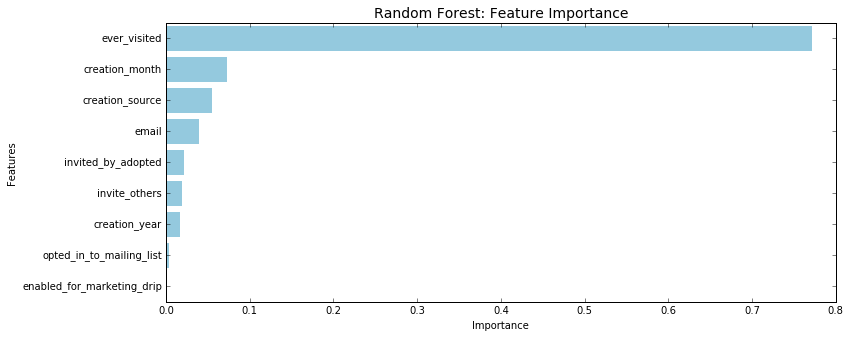

In [138]:
fig = plt.figure(figsize=(12,5))
ax = sns.barplot(x="importance", y="names", data=imp, color= "skyblue")
plt.setp(ax.patches, linewidth=0)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest: Feature Importance', fontsize='14')
#fig.savefig('rf importance.png')

** Conclusion: ** According to Random Forest, the following factors are the key to predict future user adoption:
- ever visited: whether the user has ever used the product after account creation
- creation source: the channel through which the user registered.
- creation month: the month in which the user registered.
- email: the email service the user used to register.